# Cognition and computation project

 Name and surname : Roman Gellert
 
 Matricola N. : 2109260
 
 Dataset : omniglot

In [1]:
# library imports
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize
from torchvision.transforms import Compose
from torchvision.transforms import v2
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing

from DBN import DBN

In [2]:
# checking if cuda is available and choosing it to speed up computing
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
transform = Compose([
    Resize([40, 40]),
    ToTensor()
])

omniglot_tr = tv.datasets.Omniglot(root="../omniglot", download=True, background=True, transform=transform)
omniglot_te = tv.datasets.Omniglot(root="../omniglot", download=True, background=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(omniglot_tr)

19280

In [5]:
len(omniglot_te)

13180

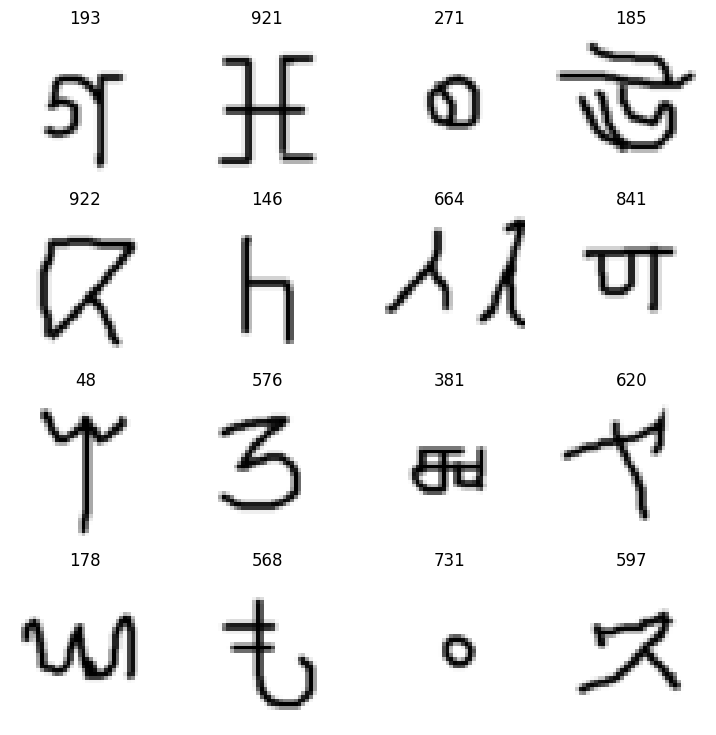

In [5]:
figure = plt.figure(figsize=(9, 9))
for i in range(1, 17):
    dataset_id = torch.randint(len(omniglot_tr), size=(1,)).item()
    img, label = omniglot_tr[dataset_id]
    figure.add_subplot(4, 4, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img[0], cmap="gray")
plt.show()

In [11]:
# loading the data
data_loader_tr = torch.utils.data.DataLoader(omniglot_tr,
                                          batch_size=len(omniglot_tr),
                                          shuffle=True)

data_loader_te = torch.utils.data.DataLoader(omniglot_te,
                                             batch_size=len(omniglot_te),
                                             shuffle=True)

In [12]:
train_data, train_labels = next(iter(data_loader_tr))
test_data, test_labels = next(iter(data_loader_te))

In [ ]:
train_labels.unique()

In [7]:
train_data = abs(1 - train_data.squeeze())
test_data = abs(1 - test_data.squeeze())

In [ ]:
train_data.unique()

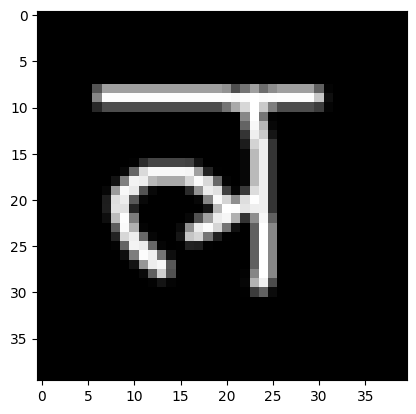

In [64]:
plt.imshow(train_data[0], cmap="gray")

## Data Augmentation 

In [8]:
image_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomAffine(13),
    v2.ElasticTransform(),
    v2.ToDtype(torch.float32, scale=True),
])

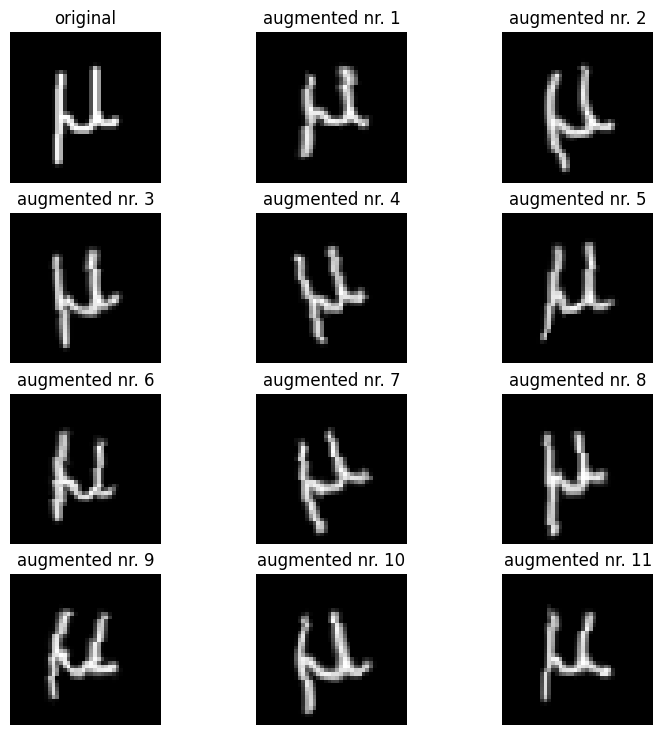

In [47]:
transformed_images = image_transforms(train_data[0])
labels_augmented_list = [train_labels[0].item()]

for _ in range(1, 12):
    transformed_image = image_transforms(train_data[0])
    transformed_images = torch.cat((transformed_images, transformed_image), 0)
    labels_augmented_list.append(train_labels[0])
    
labels_augmented = torch.tensor(labels_augmented_list)

figure = plt.figure(figsize=(9, 9))
figure.add_subplot(4, 3, 1)
plt.imshow(train_data[0], cmap="gray")
plt.axis("off")
plt.title('original')
for i in range(0, 11):
    img, label = transformed_images[i], f'augmented nr. {i+1}'
    figure.add_subplot(4, 3, i+2)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

In [48]:
transformed_image = image_transforms(train_data[0])
transformed_image[0].size()

torch.Size([40, 40])

In [9]:
augmented_training_data = []
augmented_training_labels = []

num_of_repeats = 7
for i in range(0, len(train_data)):
    if i % 3000 == 0:
        print(f'Iteration : {i}')
    for _ in range(num_of_repeats):
        transformed_image = image_transforms(train_data[i])
        augmented_training_data.append(transformed_image)
        # augmented_training_data = torch.cat((augmented_training_data, transformed_image), 0)
        augmented_training_labels.append(train_labels[i].item())

augmented_training_labels = torch.tensor(augmented_training_labels)

augmented_training_data = np.array(augmented_training_data)
augmented_training_data = torch.tensor(augmented_training_data).squeeze()

Iteration : 0
Iteration : 3000
Iteration : 6000
Iteration : 9000
Iteration : 12000
Iteration : 15000
Iteration : 18000


In [10]:
print(augmented_training_data.size())
print(augmented_training_labels.size())

torch.Size([134960, 40, 40])
torch.Size([134960])


In [11]:
train_data = torch.cat((train_data, augmented_training_data), 0)
train_labels = torch.tensor(np.concatenate([np.array(train_labels), np.array(augmented_training_labels)]))

In [12]:
print(train_data.size())
print(train_labels.size())

torch.Size([154240, 40, 40])
torch.Size([154240])


In [13]:
torch.save(train_data, "train_data.pt")
torch.save(train_labels, "train_labels.pt")

In [13]:
train_data = torch.load("train_data.pt")
train_labels = torch.load("train_labels.pt")

In [14]:
train_data.to(device)
train_labels.to(device)
test_data.to(device)
test_labels.to(device)

tensor([ 45, 380,  79,  ..., 287, 405, 249], device='cuda:0')

In [15]:
train_data_subset = train_data[0:50000]
train_labels_subset = train_labels[0:50000]

train_data_subset.to(device)
train_labels_subset.to(device)

tensor([259, 920, 115,  ..., 903, 903, 903], device='cuda:0')

# Hyperparameter tuning // Model selection

In [17]:
hidden_units = [
    [1500, 1800, 2100],
    [600, 750, 1000],
    [1700, 1700, 1700],
    [1500, 1200, 1000],
    [1500, 1600, 1800, 2300]
]

In [20]:
num_epochs = 50
batch_size = 160

for i in hidden_units:
    print(f'current model: {i}')

    dbn_mnist = DBN(visible_units=40 * 40,
                    hidden_units=i,
                    k=1,
                    learning_rate=0.1,
                    learning_rate_decay=False,
                    initial_momentum=0.5,
                    final_momentum=0.95,
                    weight_decay=0.0001,
                    xavier_init=False,
                    increase_to_cd_k=False,
                    use_gpu=torch.cuda.is_available())

    dbn_mnist.train_static(
        train_data_subset,
        train_labels_subset,
        num_epochs,
        batch_size
    )
    
    print(f'\n------------------------------\n')

current model: [1500, 1800, 2100]
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3129     |0.1320       |943.7963   |31.7594     |
|20    |1.1604     |0.1243       |961.2261   |27.1172     |
|30    |1.1190     |0.1224       |966.0942   |26.3334     |
|40    |1.0959     |0.1208       |960.8536   |28.6894     |
|50    |1.0889     |0.1197       |964.6931   |31.5986     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9580     |0.0565       |602.8849   |16.2755     |
|20    |0.8384     |0.0432       |573.1004   |18.2475     |
|30    |0.8172     |0.0416       |569.4417   |21.4109     |
|40    |0.8094     |0.0409       |570.3850   |22.3203     |
|50    |0.8052     |0.0417       |571.8655   |23.9282     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6715     |0.0503       |596.8369   |30.8966     |
|20   

In [22]:
dbn_mnist = DBN(visible_units=40 * 40,
                hidden_units=[1500, 1800, 2100],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())
num_epochs = 70
batch_size = 100

dbn_mnist.train_static(
    train_data,
    train_labels,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8547     |0.1024       |1196.8679   |32.5038     |


KeyboardInterrupt: 

In [18]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for im in range(num_subplots):
    row = im % n_rows_cols
    col = im // n_rows_cols
    axes[row, col].imshow(weights[im,:].reshape((40,40)), cmap=plt.cm.gray)  # here we select the weights we want to plot

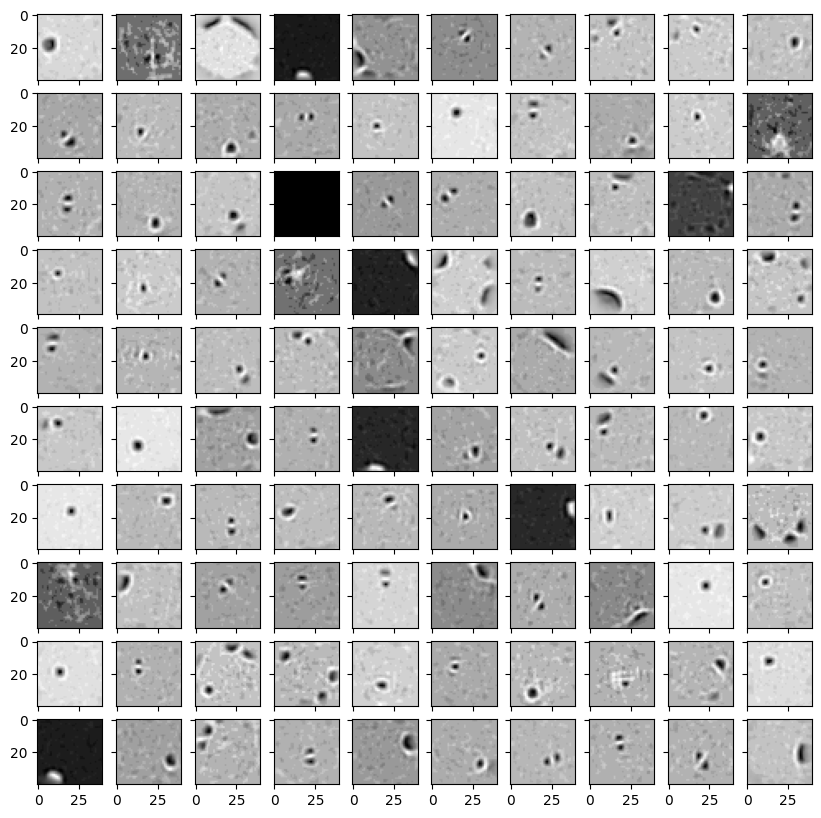

In [19]:
w1 = get_weights(dbn_mnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

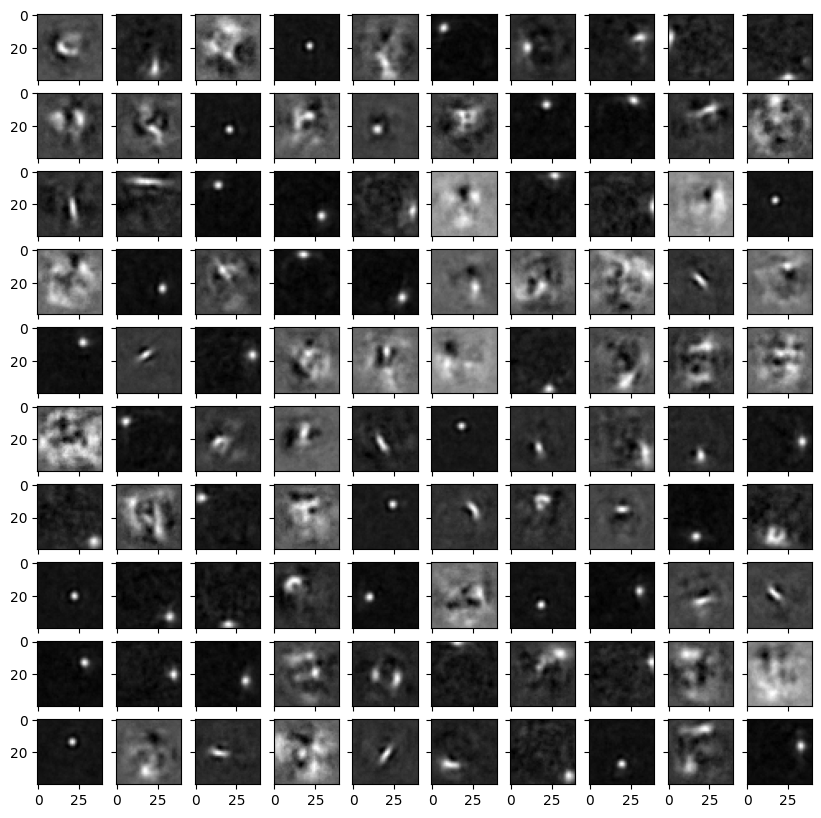

In [20]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

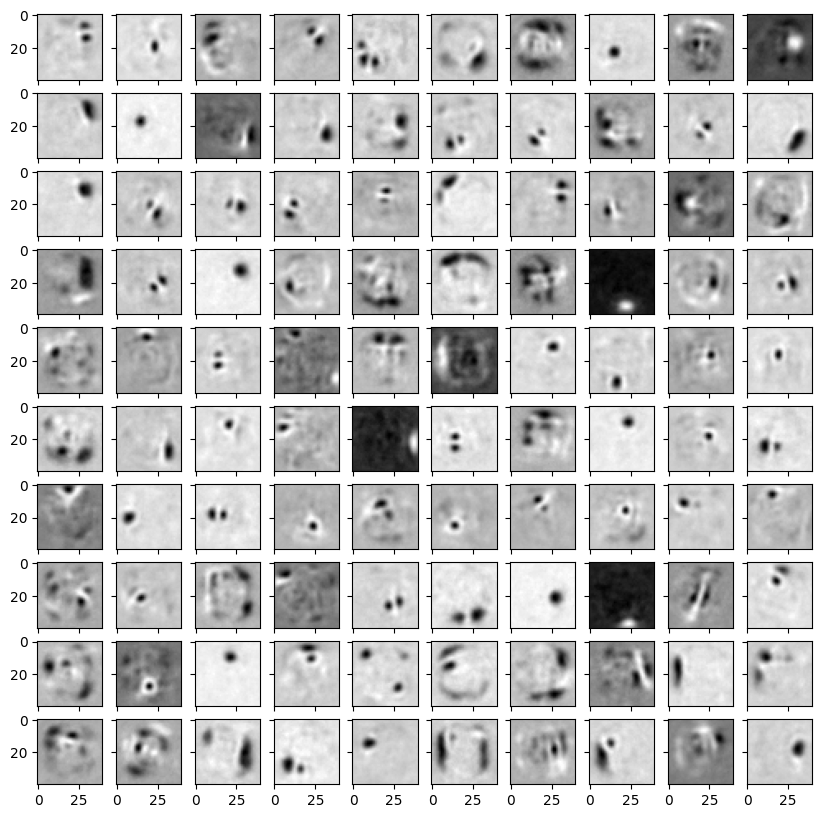

In [21]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)
w3 = get_weights(dbn_mnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)